In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
# !pip install sweetviz
# import sweetviz as sv
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sin,cos,pi
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.ensemble import BalancedBaggingClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
# %matplotlib inline
plt.style.use('seaborn')

Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [17]:
def Time_Formatx(x):
    # Formatting Time

    if x == 2400:
        x = 0

    x = "{0:04d}".format(int(x))
    T = datetime.time(int(x[0:2]), int(x[2:4]))
    
    return T


def stats(g):
    # Statistical Information for a Group

    return {'mean':g.mean(), 'variance':g.var(), 'count':g.count(), 'min':g.min(), 'max':g.max()}


def dataOverview(Airlines, Airports, Flights):

    # Dataset descriptions

    print(Flights.info(verbose = True, null_counts=True))
    print(Airlines.info(verbose = True, null_counts=True))
    print(Airports.info(verbose = True, null_counts=True))


    # Cancellation Reasons

    cancelled = Flights['CANCELLATION_REASON']
    cancelled.dropna(inplace=True)
    cancelledCount = dict(cancelled.value_counts())
    labels = ['Weather','Airline','National Air System','Security']
    sizes = cancelledCount.values()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.pie(sizes, labels=labels, pctdistance=1.25, labeldistance=1.45, autopct='%1.2f%%', startangle=90, textprops={'fontsize': 20})
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


    # Flights on Different Days of Week

    daysOfWeek = Flights['DAY_OF_WEEK']
    dayCounts = dict(daysOfWeek.value_counts())
    dayFreq = {}
    for day in sorted(dayCounts):
        dayFreq[day] = dayCounts[day]

    plt.figure(figsize=(12,8))
    flightFreq = list(dayFreq.values())
    flightFreq.append(dayFreq[1]) # add monday
    flightFreq.append(dayFreq[2]) # add tuesday
    days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Mon.','Tue...']
    plt.plot(days,flightFreq)
    plt.xlabel("Days of week", fontsize=16)
    plt.ylabel("No of flights", fontsize=16)
    plt.title("No of flights on days of week", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.show()


    # Flights in Different Months

    months = Flights['MONTH']
    monthCounts = dict(months.value_counts())
    monthFreq = {}
    for month in sorted(monthCounts):
        monthFreq[month] = monthCounts[month]

    plt.figure(figsize=(12,8))
    flightFreq = list(monthFreq.values())
    monthsArr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.plot(monthsArr, flightFreq)
    plt.xlabel("Months", fontsize=16)
    plt.ylabel("No of flights", fontsize=16)
    plt.title("No of flights on different months", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.show()


    # Delay Threshold

    ttl = Flights.shape[0]
    threshold = 3
    delayLessThanThreshold = Flights[Flights['ARRIVAL_DELAY'] <= threshold].shape[0] / ttl
    print(delayLessThanThreshold)


def exploratoryDataAnalysis(df):
    
    # # Overall analysis

    # report = sv.analyze(df)
    # report.show_html("EDA.html")


    # Air Traffic Share of Airlines

    plt.subplots(figsize=(15,20))
    plt.pie(df['AIRLINE'].value_counts(),labels=df['AIRLINE_NAME'].unique(),autopct='%1.0f%%',textprops={'fontsize': 20})
    plt.show()


    # Calculating Data Statistics

    Origin_Stats = df['ARRIVAL_DELAY'].groupby(df['ORIGIN']).apply(stats).unstack().sort_values('count',ascending=False)
    Destination_Stats = df['ARRIVAL_DELAY'].groupby(df['DESTINATION']).apply(stats).unstack().sort_values('count',ascending=False)
    Airline_Stats = df['ARRIVAL_DELAY'].groupby(df['AIRLINE']).apply(stats).unstack().sort_values('mean')
    print(Airline_Stats)


    # Airline Delays on Different Days of Week

    Days = ["Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    Airline_Day_Stats = pd.DataFrame()
    for a in df['AIRLINE'].unique():
        x = df[df['AIRLINE']==a]
        t = x['ARRIVAL_DELAY'].groupby(df['DAY']).mean()
        Airline_Day_Stats[a]=t
    Airline_Day_Stats.dropna(inplace=True)
    print(Airline_Day_Stats)

    sns.set(context="paper")
    plt.subplots(figsize=(10,8))
    plt.title("Mean Delay for Airline Vs. Day of Week")
    sns.heatmap(Airline_Day_Stats, linewidths=0.01, cmap=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256),robust=True,yticklabels=Days)
    plt.show()


    # Busiest airports and Airlines

    Airports = df['DESTINATION_CITY'].groupby(df["DESTINATION_CITY"]).count().sort_values(ascending=False).iloc[:11].keys().tolist()
    map = df[['AIRLINE_NAME','DESTINATION_CITY','ARRIVAL_DELAY']]

    frames = list()
    for x in Airports:
        frames.append(map.loc[map["DESTINATION_CITY"] == x])
    map = pd.concat(frames)

    airline_city_delay = pd.DataFrame()
    for airlines in map["AIRLINE_NAME"].unique():
        t = map.loc[map["AIRLINE_NAME"] == airlines]
        temp = t["ARRIVAL_DELAY"].groupby(t["DESTINATION_CITY"]).mean()
        airline_city_delay[airlines] = temp

    sns.set(context="paper")
    plt.subplots(figsize=(10,8))
    plt.title("Mean Delay for Airline Vs. Destination Airports")
    sns.heatmap(airline_city_delay, linewidths=0.01, cmap=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256),robust=True,yticklabels=Airports)
    plt.show()


    # Distance and Delay

    map = df[["DISTANCE","ARRIVAL_DELAY","AIRLINE_NAME"]].copy()
    interval = list()
    for i in range(0,5000,100):
        interval.append(i)

    map["DISTANCE_INTERVAL"] = pd.cut(x = map["DISTANCE"], bins = interval)
    map["DISTANCE_MID"] = map["DISTANCE_INTERVAL"].apply(lambda x : x.mid)
    newMap = map["ARRIVAL_DELAY"].groupby(map["DISTANCE_MID"]).mean().to_frame()
    newMap.dropna(inplace=True)
    newMap.plot.line(title = "Distance vs Delay graph (Bucket Size:100)")
    plt.show()


    # Distribution of Arrival Delay

    sns.displot(df['ARRIVAL_DELAY'], bins = [i for i in range(-50,100)])
    plt.show()


def preprocess(analysis = False):

    Airlines = pd.read_csv('/content/gdrive/My Drive/ML_Project/airlines.csv')
    Airports = pd.read_csv('/content/gdrive/My Drive/ML_Project/airports.csv')
    Flights = pd.read_csv('/content/gdrive/My Drive/ML_Project/flights.csv')

    if analysis:
        dataOverview(Airlines, Airports, Flights)


    # Dropping rows with NaN values and selecting data for January

    Flights = Flights.iloc[:,:23]
    Flights.dropna(inplace=True)
    Flights = Flights[Flights["MONTH"]==1]
    Flights.reset_index(inplace=True)


    # Collecting Names of Airlines and Airports

    Airline_Names = {}
    for i in range(len(Airlines)):
        Airline_Names[Airlines["IATA_CODE"][i]] = Airlines["AIRLINE"][i]

    Airport_Names = {}
    for i in range(len(Airports)):
        Airport_Names[Airports["IATA_CODE"][i]] = Airports["AIRPORT"][i]

    City_Names = {}
    for i in range(len(Airports)):
        City_Names[Airports["IATA_CODE"][i]] = Airports["CITY"][i]


    # Merging Datasets & Selecting relevant columns

    df = pd.DataFrame()
    df['DATE'] = pd.to_datetime(Flights[['YEAR','MONTH', 'DAY']])
    df['DAY'] = Flights["DAY_OF_WEEK"]
    df['AIRLINE'] = Flights["AIRLINE"]
    df['AIRLINE_NAME'] = [Airline_Names[Flights["AIRLINE"][x]] for x in range(len(Flights))]
    df['FLIGHT_NUMBER'] = Flights['FLIGHT_NUMBER']
    df['TAIL_NUMBER'] = Flights['TAIL_NUMBER']
    df['ORIGIN'] = Flights['ORIGIN_AIRPORT']
    df['ORIGIN_AIRPORT_NAME'] = [Airport_Names[Flights["ORIGIN_AIRPORT"][x]] for x in range(len(Flights))]
    df['ORIGIN_CITY'] = [City_Names[Flights["ORIGIN_AIRPORT"][x]] for x in range(len(Flights))]
    df['DESTINATION'] = Flights['DESTINATION_AIRPORT']
    df['DESTINATION_AIRPORT_NAME'] = [Airport_Names[Flights["DESTINATION_AIRPORT"][x]] for x in range(len(Flights))]
    df['DESTINATION_CITY'] = [City_Names[Flights["DESTINATION_AIRPORT"][x]] for x in range(len(Flights))]
    df['DISTANCE'] = Flights['DISTANCE']
    df['SCHEDULED_DEPARTURE'] = Flights['SCHEDULED_DEPARTURE'].apply(Time_Formatx)
    df['SCHEDULED_ARRIVAL'] = Flights['SCHEDULED_ARRIVAL'].apply(Time_Formatx)
    df['TAXI_OUT'] = Flights['TAXI_OUT']
    df['DEPARTURE_DELAY'] = Flights['DEPARTURE_DELAY']
    df['ARRIVAL_DELAY'] = Flights['ARRIVAL_DELAY']
    df = df[df.ARRIVAL_DELAY < 500]

    if analysis:
        print(df)

    if analysis:
        exploratoryDataAnalysis(df)

    # Selecting Features
    Data = df[['ARRIVAL_DELAY','ORIGIN','DESTINATION','DISTANCE','TAXI_OUT','DEPARTURE_DELAY','DATE','DAY','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL']].copy()


    # Handling Date and Time Data

    SD = Data['SCHEDULED_DEPARTURE']
    SA = Data['SCHEDULED_ARRIVAL']
    DA = Data['DATE']

    Data['SDH_Sin'] = [sin(2*pi*d.hour/24) for d in SD]
    Data['SDH_Cos'] = [cos(2*pi*d.hour/24) for d in SD]
    Data['SDM_Sin'] = [sin(2*pi*d.minute/60) for d in SD]
    Data['SDM_Cos'] = [cos(2*pi*d.minute/60) for d in SD]

    Data['SAH_Sin'] = [sin(2*pi*d.hour/24) for d in SA]
    Data['SAH_Cos'] = [cos(2*pi*d.hour/24) for d in SA]
    Data['SAM_Sin'] = [sin(2*pi*d.minute/60) for d in SA]
    Data['SAM_Cos'] = [cos(2*pi*d.minute/60) for d in SA]

    Data['DAM_Sin'] = [sin(2*pi*d.month/12) for d in DA]
    Data['DAM_Cos'] = [cos(2*pi*d.month/12) for d in DA]
    Data['DAD_Sin'] = [sin(2*pi*d.day/31) for d in DA]
    Data['DAD_Cos'] = [cos(2*pi*d.day/31) for d in DA]

    Data = Data.drop(['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DATE'],axis=1)
    Data.dropna(inplace=True)
    Data.reset_index(inplace=True,drop=True)

    if analysis:
        print(Data)


    # Handling Categorical Variables
    
    L = LabelEncoder()

    Data['AIRLINE']=L.fit_transform(np.array(Data['AIRLINE']).reshape(-1,1))
    Data['ORIGIN']=L.fit_transform(np.array(Data['ORIGIN']).reshape(-1,1))
    Data['DESTINATION']=L.fit_transform(np.array(Data['DESTINATION']).reshape(-1,1))

    H = OneHotEncoder()

    a = pd.DataFrame(H.fit_transform(np.array(Data['AIRLINE']).reshape(-1,1)).toarray())
    a.columns = [str(i) for i in range(len(a.columns))]
    b = pd.DataFrame(H.fit_transform(np.array(Data['ORIGIN']).reshape(-1,1)).toarray())
    b.columns = [str(i+len(a.columns)) for i in range(len(b.columns))]
    c = pd.DataFrame(H.fit_transform(np.array(Data['DESTINATION']).reshape(-1,1)).toarray())
    c.columns = [str(i+len(a.columns)+len(b.columns)) for i in range(len(c.columns))]

    Data = Data.drop(['AIRLINE'],axis=1)
    Data = Data.join(a)
    #Data = Data.drop(['ORIGIN'],axis=1)
    #Data = Data.join(b)
    #Data = Data.drop(['DESTINATION'],axis=1)
    #Data = Data.join(c)
    Data.dropna(inplace=True)

    if analysis:
        print(Data)


    # Splitting into X and Y

    X = Data.copy()
    X.drop(['ARRIVAL_DELAY'],axis=1, inplace = True)
    Y = Data['ARRIVAL_DELAY'].copy()

    for i in range(len(Y)):
        if Y[i]<3: Y[i]=0
        else: Y[i]=1

    X = X.to_numpy()
    Y = Y.to_numpy()
    
    if analysis:
        print("X shape: ", X.shape)
        print("Y shape: ", Y.shape)


    # Splitting into Train, Val, Test

    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0, stratify = Y)
    X_val, X_test, y_val, y_test = train_test_split( X_test, y_test, test_size=0.66, random_state=0, stratify = y_test)

    if analysis:
        print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
        print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")


    # Standard Scaling

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test


def train(model, X_train, y_train, X_val, y_val, X_test, y_test, params):

    # Logistic Regression
    if model == "logistic":

        logistic = LogisticRegression(**params)
        logistic.fit(X_train,y_train)
        y_pred = logistic.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = logistic.score(X_test,y_test)
        print("Test Score:", score)

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True);
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title("Confusion Matrix", size = 15);
        plt.show()

        return logistic

    # SGD Classifier
    if model == "sgd classifier":

        sgd = SGDClassifier(**params)
        sgd.fit(X_train,y_train)
        y_pred = sgd.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = sgd.score(X_test,y_test)
        print("Test Score:", score)

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title("Confusion Matrix", size = 15);
        plt.show()

        return sgd

    # Support Vector Machines
    if model == "svm":

        svc = BalancedBaggingClassifier(svm.LinearSVC(**params), n_jobs=-1)
        svc.fit(X_train,y_train)
        y_pred = svc.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = svc.score(X_test,y_test)
        print("Test Score:", score)

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title("Confusion Matrix", size = 15);
        plt.show()

        return svc

    # Random Forests
    if model == "rf":

        rf = RandomForestClassifier(**params)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = rf.score(X_test,y_test)
        print("Test Score:", score)

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title("Confusion Matrix", size = 15);
        plt.show()

        return rf

    # Gaussian Naive Bayes
    if model == "gnb":

        gnb = GaussianNB(**params)
        gnb.fit(X_train,y_train)
        y_pred = gnb.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = gnb.score(X_test,y_test)
        print("Test Score:", score)

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title("Confusion Matrix", size = 15);
        plt.show()

        return gnb

    # XGBoost Classifier
    if model == "xgb":

        xgb = XGBClassifier(**params)
        xgb.fit(X_train,y_train)
        y_pred = xgb.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = xgb.score(X_test,y_test)
        print("Test Score:", score)

        sns.set(context="paper")
        plt.subplots(figsize=(6,6))
        sns.heatmap(confusionMatrix, annot=True, fmt=".0f", linewidths=1.5, square = True, cmap = 'winter');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title("Confusion Matrix", size = 15);
        plt.show()

        return xgb
    # Neural Networks
    if model == "nn":
        pass


def optimalParams(model, X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    Enter the parameter and it's possible types here 
    If max_depth = 10,100,1000 and loss = L1,L2
    The code will run 3*2 times.
    For plotting the graph, please keep only 2 sets of parameters as it's a 2D graph.
    Otherwise one would have to split the array and it will lead to confusion.
    '''

    # # Logistic Regression
    if model == "logistic":

        parameters = {
            'penalty': ['l2'],
            'fit_intercept': [True, False],
            'max_iter': [2,4,6,8,10],
            'n_jobs': [-1]}

        clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1, cv=3)
        clf.fit(X_train,y_train)
        print("Best Score:", clf.best_score_)
        print("Best Parameters:", clf.best_params_)

        bestEstimator = clf.best_estimator_
        y_pred = bestEstimator.predict(X_test)
        score = bestEstimator.score(X_test,y_test)
        print("Test Score:", score)


        # Plotting the parameters

        param_xAxis_name = 'max_iter' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
        param_color_name = 'fit_intercept' # parameter that you want as the different colored curves

        param_xAxis = parameters[param_xAxis_name]
        param_color = parameters[param_color_name]

        mean_test_score = clf.cv_results_['mean_test_score']
        mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

        _, ax = plt.subplots(1,1, figsize=(9,6))

        for i in range(len(param_color)):
            ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

        ax.set_title("Grid Search CV Scores for Logistic Regression", fontsize=18, fontweight='bold')
        ax.set_xlabel(param_xAxis_name, fontsize=14)
        ax.set_ylabel('CV Avg Score', fontsize=14)
        ax.legend(fontsize=14)
        plt.show()


    # # SGDClassifier
    if model == "sgd classifier":

        parameters = {
            'penalty': ['l1','l2'],
            'max_iter': [50, 100, 250, 500, 1000, 2500, 5000, 7500, 10000],
            'n_jobs': [-1]}

        clf = GridSearchCV(SGDClassifier(), parameters, n_jobs=-1, cv=4)
        clf.fit(X_train,y_train)
        print("Best Score:", clf.best_score_)
        print("Best Parameters:", clf.best_params_)

        bestEstimator = clf.best_estimator_
        y_pred = bestEstimator.predict(X_test)
        score = bestEstimator.score(X_test,y_test)
        print("Test Score:", score)

        # Plotting the parameters

        param_xAxis_name = 'max_iter' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
        param_color_name = 'penalty' # parameter that you want as the different colored curves

        param_xAxis = parameters[param_xAxis_name]
        param_color = parameters[param_color_name]

        mean_test_score = clf.cv_results_['mean_test_score']
        mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

        _, ax = plt.subplots(1,1, figsize=(9,6))

        for i in range(len(param_color)):
            ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

        ax.set_title("Grid Search CV Scores for SGD Classifier", fontsize=18, fontweight='bold')
        ax.set_xlabel(param_xAxis_name, fontsize=14)
        ax.set_ylabel('CV Avg Score', fontsize=14)
        ax.legend(fontsize=14)
        plt.show()


    # Support Vector Machines
    if model == "svm":

        parameters = {
            'penalty': ['l1','l2'],
            'max_iter': [50, 100, 250, 500, 1000, 2500, 5000, 7500, 10000]}

        clf = GridSearchCV(svm.LinearSVC(), parameters, n_jobs=-1, cv=4)
        clf.fit(X_train,y_train)
        print("Best Score:", clf.best_score_)
        print("Best Parameters:", clf.best_params_)

        bestEstimator = clf.best_estimator_
        y_pred = bestEstimator.predict(X_test)
        score = bestEstimator.score(X_test,y_test)
        print("Test Score:", score)

        # Plotting the parameters

        param_xAxis_name = 'max_iter' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
        param_color_name = 'penalty' # parameter that you want as the different colored curves

        param_xAxis = parameters[param_xAxis_name]
        param_color = parameters[param_color_name]

        mean_test_score = clf.cv_results_['mean_test_score']
        mean_test_score = np.array(mean_test_score).reshape(len(param_color), len(param_xAxis))

        _, ax = plt.subplots(1,1, figsize=(9,6))

        for i in range(len(param_color)):
            ax.plot(param_xAxis, mean_test_score[i,:], label=param_color_name+': ' + str(param_color[i]))

        ax.set_title("Grid Search CV Scores for SVC", fontsize=18, fontweight='bold')
        ax.set_xlabel(param_xAxis_name, fontsize=14)
        ax.set_ylabel('CV Avg Score', fontsize=14)
        ax.legend(fontsize=14)
        plt.show()


    # Random Forests
    if model == "rf":
        
        parametersrf = {
            'criterion': ["gini", "entropy"],
            'class_weight': [None, "balanced"],
            'n_estimators': [200,400,600]
            }

        clf = GridSearchCV(RandomForestClassifier(), parametersrf, n_jobs=-1, cv=3)
        clf.fit(X_train,y_train)
        print("Best Score:", clf.best_score_)
        print("Best Parameters:", clf.best_params_)
        bestEstimatorrf = clf.best_estimator_

        y_pred = bestEstimatorrf.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = bestEstimatorrf.score(X_test,y_test)
        print("Test Score:", score)

        param_xAxis_name = 'n_estimators' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
        param_color_name = 'criterion' # parameter that you want as the different colored curves

        param_xAxis = parametersrf[param_xAxis_name]
        param_color = parametersrf[param_color_name]
        param_label = parameters["class_weight"]
        mean_test_score = clf.cv_results_['mean_test_score']
        mean_test_score_none = mean_test_score[:len(mean_test_score)//2]
        mean_test_score_bal = mean_test_score[len(mean_test_score)//2:]
        mean_test_score_none = np.array(mean_test_score_none).reshape(len(param_color), len(param_xAxis))
        mean_test_score_bal = np.array(mean_test_score_bal).reshape(len(param_color), len(param_xAxis))


        _, ax = plt.subplots(1,1, figsize=(9,6))

        for i in range(len(param_color)):
            ax.plot(param_xAxis, mean_test_score_none[i,:], label=param_color_name+': ' + str(param_color[i]) + ", class weight:" + str(param_label[i]))
            ax.plot(param_xAxis, mean_test_score_bal[i,:], label=param_color_name+': ' + str(param_color[i]) + ", class weight:" + str(param_label[i]))

        ax.set_title("Grid Search CV Scores for Random Forest Classifier", fontsize=18, fontweight='bold')
        ax.set_xlabel(param_xAxis_name, fontsize=14)
        ax.set_ylabel('CV Avg Score', fontsize=14)
        ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), title = "Criterion, class weight")
        plt.setp(legend.get_title(),fontsize='x-large')
        plt.show()


    # Gaussian Naive Bayes
    if model == "gnb":

        parametersnb = {
            "var_smoothing": [10**-20,10**-11,10**-9, 10**-7, 10**-5, 10**-2]
            }

        clf = GridSearchCV(GaussianNB(), parametersnb, n_jobs=-1, cv=3)
        clf.fit(X_train,y_train)
        print("Best Score:", clf.best_score_)
        print("Best Parameters:", clf.best_params_)
        bestEstimatornb = clf.best_estimator_
        y_pred = bestEstimatornb.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        print(confusionMatrix)
        scorenb = bestEstimatornb.score(X_test,y_test)
        print("Test Score:", scorenb)

        param_xAxis_name = 'var_smoothing' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
        param_xAxis = parameters[param_xAxis_name]
        param_label = parameters[param_xAxis_name]
        print(clf.cv_results_["params"])
        mean_test_score = clf.cv_results_['mean_test_score']

        _, ax = plt.subplots(1,1, figsize=(9,6))

        ax.plot(param_xAxis, mean_test_score)
        ax.set_title("Grid Search CV Scores for Gaussian naive bayes", fontsize=18, fontweight='bold')
        ax.set_xlabel(param_xAxis_name, fontsize=14)
        ax.set_ylabel('CV Avg Score', fontsize=14)
        plt.show()


    # XGBoost Classifier
    if model == "xgb":

        parameters = {
            'max_depth':[5,7,15],
            'learning_rate': [0.01,0.001,0.1],
            'class_weight': [None, "balanced"],
            'n_estimators': [100,200,300]
            }

        clf = GridSearchCV(XGBClassifier(), parameters, n_jobs=-1, cv=3)
        clf.fit(X_train,y_train)
        print("Best Score:", clf.best_score_)
        print("Best Parameters:", clf.best_params_)
        bestEstimator = clf.best_estimator_
        y_pred = bestEstimator.predict(X_test)

        confusionMatrix = metrics.confusion_matrix(y_test, y_pred)
        score = bestEstimator.score(X_test,y_test)
        print("Test Score:", score)

        # Plotting the parameters

        param_xAxis_name = 'n_estimators' # parameter that you want in the x axis. (max_iter, n_estimators etc. are preferred)
        param_color_name = 'max_depth' # parameter that you want as the different colored curves

        param_xAxis = parameters[param_xAxis_name]
        param_color = parameters[param_color_name]
        param_breaks = clf.cv_results_["params"]
        mean_score = clf.cv_results_["mean_test_score"]
        scores_list = [[] for i in range(6)]
        j, k = len(param_xAxis)*len(param_color), 0
        labels = dict()
        for i in param_breaks:
            scores_list[k//j].append(mean_score[k]) 
            labels["learning_rate:"+str(clf.cv_results_["params"][k]["learning_rate"]) + ", class_weight:"+str(clf.cv_results_["params"][k]["class_weight"])] = k//j
            k += 1

        labels = {v: k for k, v in labels.items()}
        mean_test_score = np.array(scores_list).reshape(len(scores_list), len(param_color), len(param_xAxis))

        _, ax = plt.subplots(1,1, figsize=(9,6))

        for i in range(len(param_color)):
            for j in range(len(mean_test_score)):
                ax.plot(param_xAxis, mean_test_score[j,i,:], label=param_color_name+': ' + str(param_color[i]) + "," + labels[j])
            

        ax.set_title("Grid Search CV Scores for XGB Classifier", fontsize=18, fontweight='bold')
        ax.set_xlabel(param_xAxis_name, fontsize=14)
        ax.set_ylabel('CV Avg Score', fontsize=14)
        ax.legend(fontsize=14,  bbox_to_anchor=(1, 1.1), title = "max depth, learning rate, class weight")
        plt.setp(legend.get_title(),fontsize='x-large')
        plt.show()

    return clf

def plotRocAuc(model, X_test, y_test):

    y_pred = model.predict_proba(X_test)

    fpr, tpr, threshold= metrics.roc_curve(y_test, y_pred[:, 1])
    roc_auc = metrics.auc(fpr, tpr)

    plt.subplots(figsize=(9,7))
    plt.title("Receiver Operating Characteristic", fontsize=14)
    plt.plot(fpr, tpr, label = "Logistic Regression AUC = %0.2f"%roc_auc)
    plt.plot([0,1], [0,1], "--", label="No skill")
    plt.legend(loc = "lower right", prop={'size': 12})
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")

    plt.show()        

def process(analysis = False):
    '''
      Calls preprocess on the train and test set - Link to the dataset : https://drive.google.com/drive/folders/1HRDxih_6xN0uU2Js3xGF8zp5r_XPSEJc?usp=sharing

      Parameters
      ----------
      analysis : Default False, If set to true, displays all the analytical & statistical graphs for the dataset provided.

      Returns
      -------
      A stratified 70-10-20 split of the dataset
    '''
    X_train, y_train, X_val, y_val, X_test, y_test = preprocess(analysis)
    return X_train, y_train, X_val, y_val, X_test, y_test

def runner(model, data, optimal = False, params = {}):
    '''
      Trains the models, Plots confusion matrix and roc-auc curve.

      Parameters
      ----------
      model : {
        'logistic' : logistic regression model
        'sgd classifier' : SGD classifier
        'svm' : Linear SVM model - Used in tandem with Balanced bagging classifier
        'rf' : Random forest
        'gnb' : Gaussian naive bayes
        'xgb' : XGB boost
      }
      optimal : Default False, If set to true, performs a grid search on predetermined hyperparameters and trains the model based on those parameters
      params : parameters that you want to pass to the model - Default is an empty dictionary. If optimal set to true, there is no need to pass params

    Returns
    ------
    None, but accuracy is printed
    '''
    X_train, y_train, X_val, y_val, X_test, y_test = data
    if optimal:
        trainedModel = optimalParams(model, X_train, y_train, X_val, y_val, X_test, y_test)
    else:
        trainedModel = train(model, X_train, y_train, X_val, y_val, X_test, y_test, params)
    if model != "sgd classifier":
      plotRocAuc(trainedModel, X_test, y_test)

In [8]:
data = process(analysis = False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Score: 0.8732118773353379


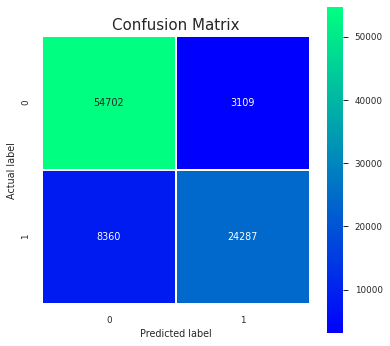

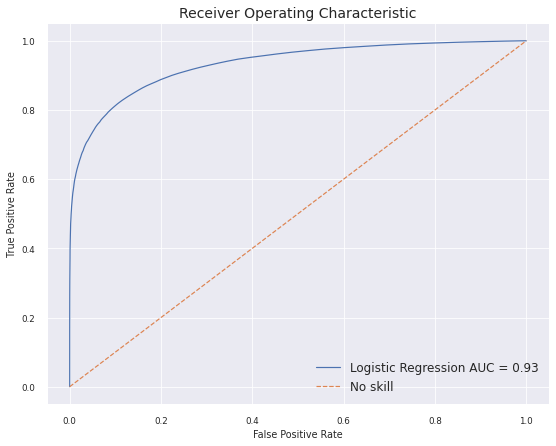

In [15]:
paramsrf = {'class_weight': None, 'criterion': 'entropy', 'n_estimators': 400}
runner(model = "rf", data = data, optimal = False)

Test Score: 0.8765836078622123


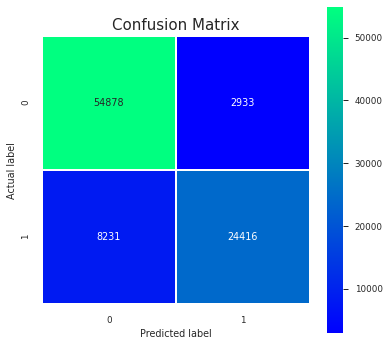

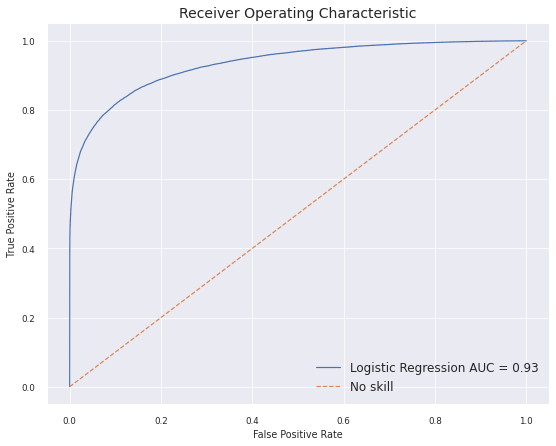

In [12]:
paramsxgb = {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 7, 'n estimators': 300}
runner(model = "xgb", data = data, optimal = False, params = paramsxgb) 

Test Score: 0.8200933029693338


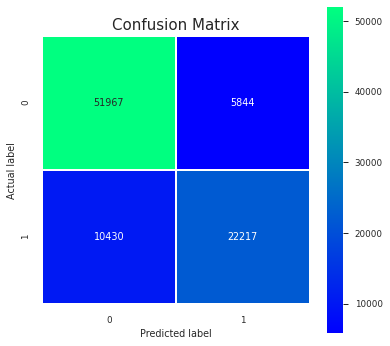

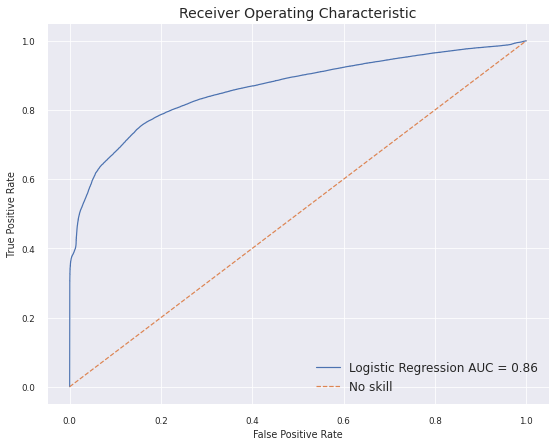

In [13]:
runner(model = "gnb", data = data, optimal = False)

Test Score: 0.8641911163191758


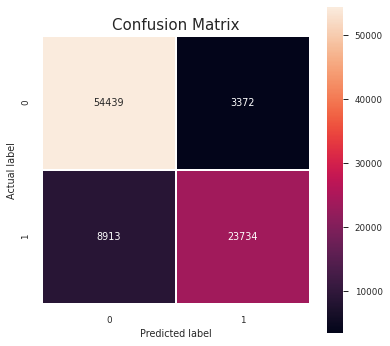

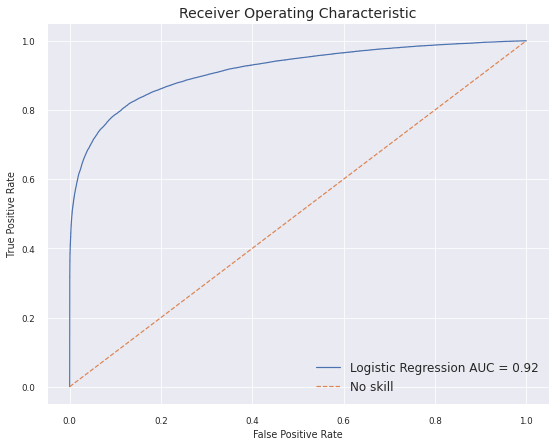

In [14]:
runner(model = "logistic", data = data, optimal = False)

Test Score: 0.8626213270246965


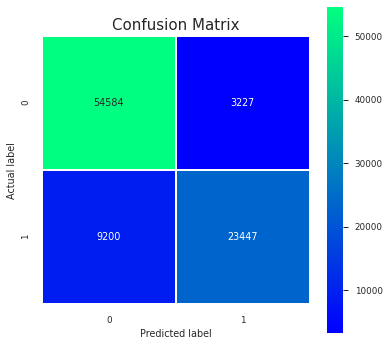

In [18]:
paramssgd = {'max_iter': 10000, 'n_jobs': -1, 'penalty': 'l1'}
runner(model = "sgd classifier", data = data, optimal = False, params = paramssgd) 